<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-To-Probabilistic-Graphical-Models----Practical-Session-1" data-toc-modified-id="Introduction-To-Probabilistic-Graphical-Models----Practical-Session-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction To Probabilistic Graphical Models -- Practical Session 1</a></span><ul class="toc-item"><li><span><a href="#Question-0" data-toc-modified-id="Question-0-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Question 0</a></span></li><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Question 1</a></span><ul class="toc-item"><li><span><a href="#1-Choose-the-appropriate-random-variables,-define-their-domains,-write-down-the-generative-model-and-draw-the-associated-directed-graphical-model." data-toc-modified-id="1-Choose-the-appropriate-random-variables,-define-their-domains,-write-down-the-generative-model-and-draw-the-associated-directed-graphical-model.-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>1 Choose the appropriate random variables, define their domains, write down the generative model and draw the associated directed graphical model.</a></span></li><li><span><a href="#3" data-toc-modified-id="3-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>3</a></span></li><li><span><a href="#4-Implement-a-program-that-simulates-this-scenario;-i.e.,-generates-realizations-from-the-movements-of-the-robot-and-the-associated-sensor-readings.-Simulate-a-scenario-for-$k-=-1...100$-with-$N-=-50$,-$\epsilon-=-0,3$,$-w-=-0.8$." data-toc-modified-id="4-Implement-a-program-that-simulates-this-scenario;-i.e.,-generates-realizations-from-the-movements-of-the-robot-and-the-associated-sensor-readings.-Simulate-a-scenario-for-$k-=-1...100$-with-$N-=-50$,-$\epsilon-=-0,3$,$-w-=-0.8$.-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>4 Implement a program that simulates this scenario; i.e., generates realizations from the movements of the robot and the associated sensor readings. Simulate a scenario for $k = 1...100$ with $N = 50$, $\epsilon = 0,3$,$ w = 0.8$.</a></span></li></ul></li></ul></li></ul></div>

# Introduction To Probabilistic Graphical Models -- Practical Session 1

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import circulant

## Question 0

In [98]:
def logsumexp(X):
    '''
    Returns $log(\sigma{exp(l_i)})$
    '''
    l_ = np.max(X)
    return l_ + np.log(np.exp((X - l_)).sum())

In [99]:
data = np.array([-1234.,-1235.], dtype=np.float64)
logsumexp(data)

-1233.6867383124818

## Question 1

### 1 Choose the appropriate random variables, define their domains, write down the generative model and draw the associated directed graphical model.
D'après le sujet, chaque possible position est un état de robot.On definie la $y_t$, la variable d'état au temps t.On peut donc definie la problabilité de transition comme ci-dessous:

$P(y_t = j | y_{t-1} = i) =  a_{i,j} = 
\begin{cases}
\epsilon  &  si\: j=i \\
1-\sigma  &  si\: j=i+1 \\
0 & autre cas\\
\end{cases}
$

La matrix des probabilités de transitions 

$A = [a_{i,j}]$

Comme la distribution du positions initial est uniforme. Le vecteur de probabilités initiales est donc sous forme ci-dessous

$\Pi ={\pi_i} $ où $i \in [1,N] $ avec $\pi_i = \frac{1}{N}$

La probabilités d'observation des positions est donc 
$ b_{ij} = p(y_{1:k} = j |x_{i:k} = i) = 
\begin{cases}
\frac{1}{N} + w(1-\frac{1}{N})  &  j = i \\
(1-w)(1-\frac{1}{N})  &  j\neq i \\
\end{cases}
$


###  3 

### 4 Implement a program that simulates this scenario; i.e., generates realizations from the movements of the robot and the associated sensor readings. Simulate a scenario for $k = 1...100$ with $N = 50$, $\epsilon = 0,3$,$ w = 0.8$.

In [100]:
def setup_model():
    '''
    Setup the parametre for the hidden markov model
    
    Returns:
    pri : Probabilité initial
    A : Transition matrix
    B : Observation matrix
     
    '''
    
    # Nombre des états
    N = 50

    # Matrix de trantision
    ep = 0.7
    A = ep * np.eye(N) + (1 - ep) * np.roll(np.eye(N), 1, axis=1)

    # Observation model
    w = 0.7
    B = w * np.eye(N) + (1-w) * np.ones((N,N))/N
    
    # Prior p(x_1)
    pri = np.ones(N, dtype=np.float64) / N
    
    return [pri,A, B]

In [101]:
def seq_gene(model, K):
    '''
    Generate data from the model specified by the arguments.
    
    Params:
        model : The morkov model
        K : Numbre of time slices to simulate
        
    Returns:
        states : State sequence
        obs : Observation sequence 
    '''

    # Gene value init:
    states = np.zeros(K, dtype=np.int8)
    obs = np.zeros(K, dtype=np.int8)
    pri, A, B = model
    N = pri.shape[0]

    states[0] = np.random.choice(N, p=pri)
    obs[0] = np.random.choice(N, p=B[0])

    for k in range(1, K):
        states[k] = np.random.choice(N, p=A[states[k-1]])
        obs[k] = np.random.choice(N, p=B[states[k]])
        
    return [states, obs]

Text(0.5, 0, 'time')

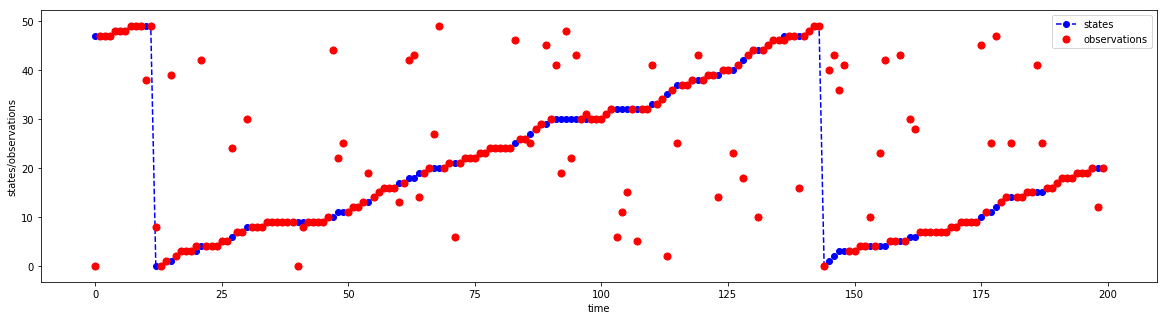

In [102]:
# Visualization for generation of sequences
K = 200
states, obs = seq_gene(setup_model(), K)

plt.figure(figsize=(20,5))
plt.plot(states, 'bo--', zorder=0)
plt.scatter(np.arange(K), obs, marker='o', c='r', s=50, zorder=1)
plt.legend(['states', 'observations'])
plt.ylabel('states/observations')
plt.xlabel('time')

In [103]:
def state_predict(A, log_p):
    mx = np.max(log_p)
    p = np.exp(log_p - mx)
    return np.log(A.T.dot(np.exp(log_p-mx))) + mx

def state_update(obs, log_p):
    return np.log(obs) + log_p
    
def forward_method(hm, obs_seq):
    # Initiliaze parameter
    pri, A, B = hm
    log_B = np.log(B)
    K, N = len(obs_seq), A.shape[0]
    alpha = np.zeros((N, K))
    alpha_pred = np.zeros((N, K))

    alpha[:,0] = np.log(B[:,obs_seq[0]] * pri)
    #print(alpha[:,0],B[:,obs_seq[0]], pri)

    for k in np.arange(1, K):
        alpha_pred[:, k] = state_predict(A, alpha[:,k-1])
        alpha[:, k] = log_B[:, obs_seq[k]]  + alpha_pred[:, k]   

    return alpha, alpha_pred

In [104]:
# Test
pri = np.array([0.2, 0.4, 0.4])
A = np.array([[0.5, 0.2, 0.3],
    [0.3,0.5, 0.2],
    [0.2,0.3,0.5]])
B = np.array([[0.5,0.5], [0.4,0.6], [0.7,0.3]])
model = [pri, A, B]
[alpha,alpha__pred] = forward_method(model, np.array([0,1,0]))
alpha = np.exp(alpha)
alpha

array([[0.1     , 0.077   , 0.04187 ],
       [0.16    , 0.1104  , 0.035512],
       [0.28    , 0.0606  , 0.052836]])

In [105]:
model = setup_model()
[alpha, alpha_pred] = forward_method(model,
                       seq_gene(model, 100)[0])
# print(alpha_pred[:,2]/norm[2])

# norm = alpha_pred.sum(axis=0)
# for k in range(100):
#     alpha_pred[:,k] = alpha_pred[:,k] / norm[k]
# np.exp(alpha_update)

norm = np.linalg.norm(np.exp(alpha), axis=0)
for k in range(100):
    alpha[:,k] = np.exp(alpha[:,k]) / norm[k]
alpha.max(axis=0)

norm = np.linalg.norm(np.exp(alpha_pred), axis=0)
for k in range(100):
    alpha_pred[:,k] = np.exp(alpha_pred[:,k]) / norm[k]
alpha.max(axis=0)

array([0.99823515, 0.9999929 , 0.99980678, 0.99999346, 0.99980669,
       0.99999346, 0.99980669, 0.99999346, 0.99999326, 0.99999325,
       0.99999325, 0.99999325, 0.99999325, 0.99999325, 0.99999325,
       0.99980677, 0.99999346, 0.99999326, 0.99999325, 0.99999325,
       0.99999325, 0.99999325, 0.99999325, 0.99999325, 0.99999325,
       0.99999325, 0.99980677, 0.99999346, 0.99999326, 0.99999325,
       0.99999325, 0.99980677, 0.99980007, 0.99999346, 0.99999326,
       0.99980677, 0.99980007, 0.99999346, 0.99980668, 0.99999346,
       0.99980669, 0.99999346, 0.99999326, 0.99999325, 0.99980677,
       0.99999346, 0.99999326, 0.99999325, 0.99999325, 0.99999325,
       0.99980677, 0.99980007, 0.99979998, 0.99999346, 0.99999326,
       0.99999325, 0.99999325, 0.99980677, 0.99999346, 0.99999326,
       0.99999325, 0.99999325, 0.99999325, 0.99999325, 0.99999325,
       0.99999325, 0.99980677, 0.99999346, 0.99999326, 0.99999325,
       0.99980677, 0.99980007, 0.99999346, 0.99999326, 0.99980

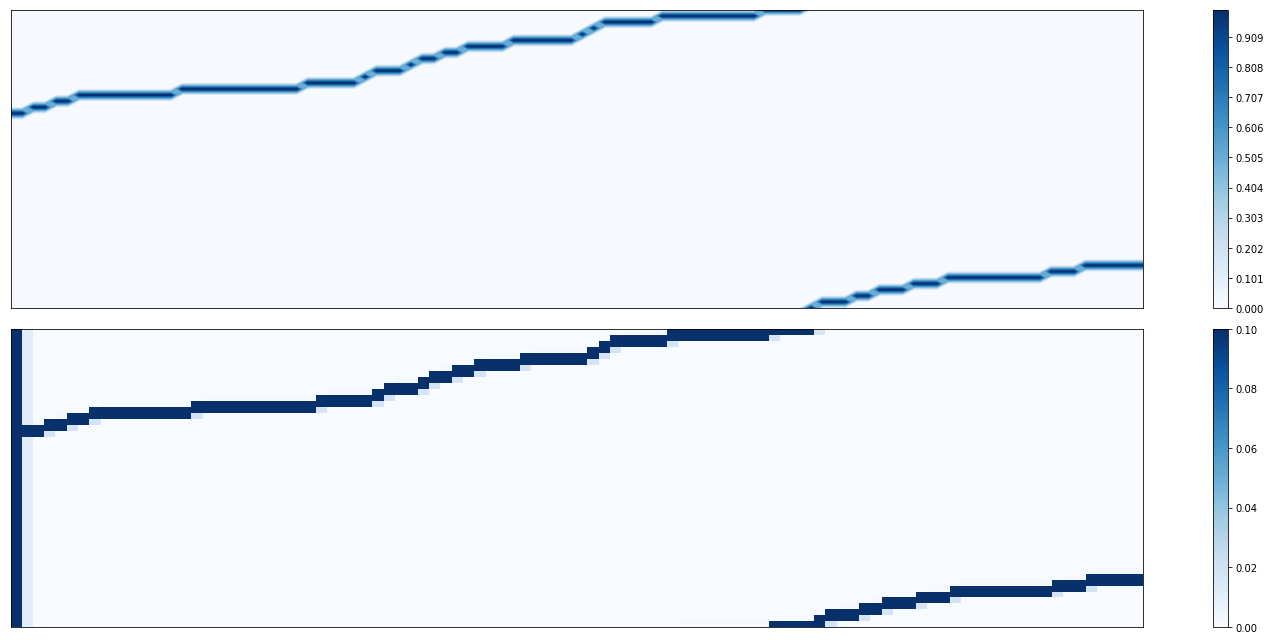

In [106]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(20,9)
# tricontourf ignores the vmin, vmax, so we need to manually set the levels
# in this case we use 11-1=10 equally spaced levels.
im = ax[0].contourf(np.arange(100), 
                       np.arange(50), 
                       alpha, 
                       levels=np.linspace(0,1.0,100), cmap='Blues' )
# pcolor works as expected
im2 = ax[1].pcolor(alpha_pred, cmap='Blues', vmin=0, vmax=0.1 )

plt.colorbar(im, ax=ax[0])
plt.colorbar(im2, ax=ax[1])

for axis in ax:
    axis.set_yticks([])
    axis.set_xticks([])
plt.tight_layout()
plt.show()

# plt.figure(figsize=(20,5))
# plt.contourf(np.arange(100), np.arange(50), alpha, cmap='gray_r')
# plt.clim(0.000,1.0)
# plt.colorbar();


# plt.figure(figsize=(20,5))
# plt.contourf(np.arange(100), np.arange(50), alpha_pred, cmap='gray_r')
# plt.colorbar();
# plt.clim(0,1)

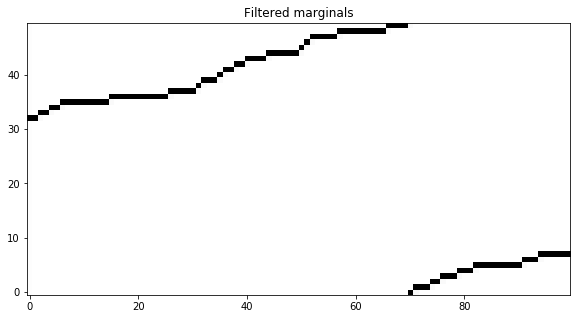

In [107]:
plt.figure(figsize=(20,5))
plt.imshow(alpha, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Filtered marginals')
plt.show()

In [108]:
alpha

array([[8.48358483e-03, 1.02804716e-04, 2.88684307e-06, ...,
        5.11978965e-54, 4.38096447e-56, 3.74858324e-58],
       [8.48358483e-03, 1.02804716e-04, 2.88684307e-06, ...,
        2.93755690e-48, 2.49650913e-50, 2.12168075e-52],
       [8.48358483e-03, 1.02804716e-04, 2.88684307e-06, ...,
        1.77556805e-44, 1.50908833e-46, 1.28260226e-48],
       ...,
       [8.48358483e-03, 1.02804716e-04, 2.88684307e-06, ...,
        5.20640534e-82, 4.42470706e-84, 3.76037427e-86],
       [8.48358483e-03, 1.02804716e-04, 2.88684307e-06, ...,
        9.81350617e-64, 8.34009018e-66, 7.08789534e-68],
       [8.48358483e-03, 1.02804716e-04, 2.88684307e-06, ...,
        8.20055472e-56, 6.96930996e-58, 5.92292634e-60]])

[[32.08793516 71.62925988  1.95992107]
 [35.51768055  5.70893721 60.77746033]
 [38.14909657 24.72455544 28.44515379]]
[[32.08793516 71.62925988  1.95992107]
 [35.51768055  5.70893721 60.77746033]
 [38.14909657 24.72455544 28.44515379]]


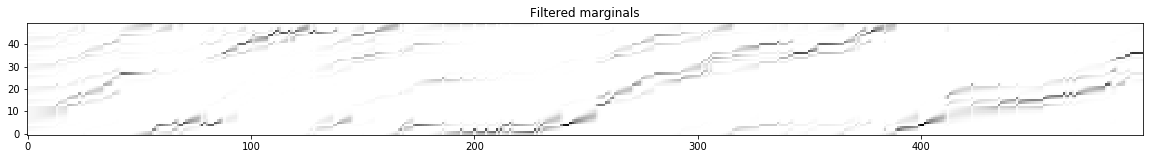

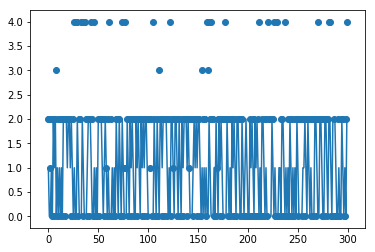

In [143]:
import numpy as np

from HiddenMarkovModel import *
    
hm = HMM.from_random_parameters()

y,x = hm.generate_sequence(300)

log_alpha, log_alpha_pred = hm.forward(y)
log_gamma = hm.forward_backward_smoother(y)
log_gamma_corr, C1_corr, C2_corr, C3_corr = hm.correction_smoother(y)
C1, C2, C3, ll, V = hm.forward_only_SS(y)

print(C2)
print(C2_corr)

plt.figure(figsize=(20,5))
plt.imshow(alpha, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Filtered marginals')
plt.show()


plt.plot(x)
plt.scatter(np.arange(len(y)), y)

E:\github\Telecom_Paristech-3rd_year\DATA905-Introduction_to_Graphical_Models\TP1_HMM\HiddenMarkovModel.py:17: RuntimeWarning: divide by zero encountered in log
  self.logA = np.log(self.A)


[1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0] [16 16 16 16 17 17 17 17 17 18 19 19 19 19 20 20 21 21 21 22 22 23 23 23
 24 24 25 25 25 25 25 25 26 26 27 27 27 28 28 29 29 29 30 30 31 31 31 32
 33 33 34 34 35 35 36 36 37 38 38 39 39 39 39 39 39 39 39 40 41 42 42 43
 43 43 43 43 43 43 44 45 45 45 46 47 47 47 47 48 48 48 49 49  0  0  0  1
  1  1  2  2  3  3  3  4  5  5  5  5  5  5  5  5  6  6  7  8  8  9 10 10
 10 10 10 11 11 12 12 13 13 13 13 14 14 14 14 14 14 14 15 16 17 17 17 17
 17 17 17 17 18 19 19 19 19 19 19 19 19 19 20 21 22 22 22 22 23 23 23 24
 24 24 24 25 25 26 26 27 28 29 29 29 30 30 30 30 30 31 32 32 32 32 33 33
 33 34 34

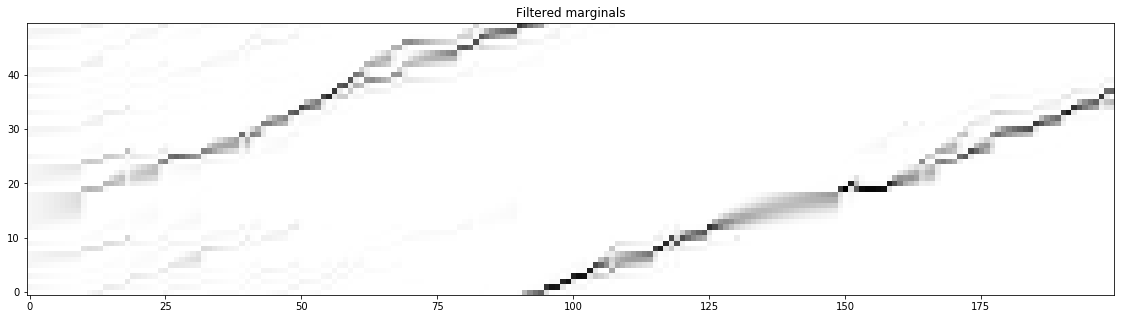

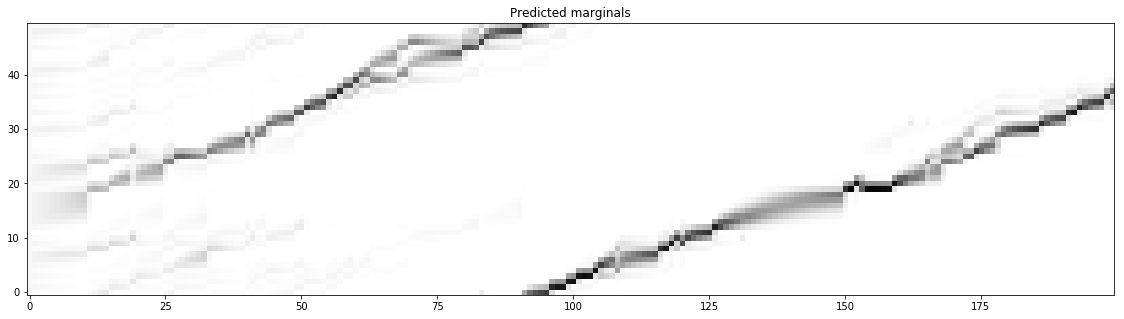

In [148]:
# Number of states
S = 50

# Probability of staying on the same tile
ep = 0.7
# Probability of making an arbitrary jump
kidnap = 0.01
# Probability of correct observation
a = 0.9

# Set up the transition matrix
idx = [i for i in range(1,S)]+[0]
I = np.diag(np.ones(S))
A2 = (1-kidnap)*(ep*I + (1-ep)*I[:,idx]) + kidnap*np.ones((S,S))/S
kidnap = 0.0
A = (1-kidnap)*(ep*I + (1-ep)*I[:,idx]) + kidnap*np.ones((S,S))/S

# Set up the observation matrix
c = a*np.random.randint(0,2, S) + (1-a)*np.ones(S)/2
C = np.array([c,1-c])

# Prior
p0 = np.ones(S)/S
#p0 = np.random.rand(S)
p0 = p0/sum(p0)

hm2 = HMM(p0, A2, C)

T = 200
y,x = hm2.generate_sequence(T)
xs = list()
hm = HMM(p0, A, C)
y,x = hm2.generate_sequence(T)

log_alpha, log_alpha_pred = hm.forward(y)
log_gamma = hm.forward_backward_smoother(y)
xs = hm.viterbi(y)

alpha = normalize_exp(log_alpha, axis=0)
alpha_pred = normalize_exp(log_alpha_pred, axis=0)
gam = normalize_exp(log_gamma, axis=0)


# plt.figure(figsize=(hm.S//5,1))
# plt.imshow(C[1,:].reshape(1,hm.S), interpolation='nearest', cmap='gray_r')
# ax = plt.gca()
# ax.set_yticks([])
# ax.invert_yaxis()
# plt.title('Probability of observing a black tile at state x')
# plt.show()


# plt.figure(figsize=(20,5))
# plt.imshow(y.reshape(1,len(y)), interpolation='nearest', cmap='gray_r')
# ax = plt.gca()
# ax.set_yticks([])
# ax.invert_yaxis()
# plt.title('Observations')
# plt.xlabel('time')
# plt.show()

plt.figure(figsize=(20,5))
plt.imshow(alpha, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Filtered marginals')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(alpha_pred, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Predicted marginals')
plt.show()

# plt.figure(figsize=(20,5))
# plt.imshow(gam, interpolation='nearest', cmap='gray_r')
# plt.plot(xs,'wo')
# plt.plot(x,'.')
# ax = plt.gca()
# ax.invert_yaxis()
# ax.set_xlim((-0.5,T-0.5))
# ax.set_ylim((-0.5,S-0.5))
# plt.title('Smoothed marginals')

plt.show()

In [128]:
alpha.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.